In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from tqdm.notebook import tqdm
from colour_mappings import line_colours, line_names
from graph_loading import load_graph

In [2]:
G, pos, colors, weights, index_to_station_name, station_name_to_index = load_graph()

In [3]:
def create_shortest_paths_animation(G, start_node, pos, color_dict, interval=100):
    """
    Animate Dijkstra's algorithm showing shortest paths to all stations.
    Dynamically scales and builds up the graph as it explores.
    """
    fig, ax = plt.subplots(figsize=(30, 20))
    
    # Calculate shortest paths
    distances, paths = nx.single_source_dijkstra(G, start_node)
    max_distance = max(distances.values())
    frames = []
    
    # Create frames showing paths in order of increasing distance
    sorted_nodes = sorted(distances.keys(), key=lambda x: distances[x])
    for i, node in enumerate(sorted_nodes):
        frames.append({
            'current_node': node,
            'distance': distances[node],
            'visited_nodes': sorted_nodes[:i+1],
            'paths': {n: paths[n] for n in sorted_nodes[:i+1]}
        })
    
    def update(frame):
        ax.clear()
        
        # Get all currently visible nodes (nodes in paths)
        visible_nodes = set()
        for node, path in frames[frame]['paths'].items():
            visible_nodes.update(path)
        
        # Calculate plot bounds based on visible nodes
        if visible_nodes:
            x_coords = [pos[node][0] for node in visible_nodes]
            y_coords = [pos[node][1] for node in visible_nodes]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            # Add margin based on the size of the current view
            x_margin = (x_max - x_min) * 0.1
            y_margin = (y_max - y_min) * 0.1
            
            plt.xlim(x_min - x_margin, x_max + x_margin)
            plt.ylim(y_min - y_margin, y_max + y_margin)
        
        # Draw discovered paths
        edges_drawn = set()  # Keep track of drawn edges to avoid duplicates
        for node, path in frames[frame]['paths'].items():
            path_edges = list(zip(path[:-1], path[1:]))
            
            for start, end in path_edges:
                if (start, end) not in edges_drawn and (end, start) not in edges_drawn:
                    # Find the edge and its line in the graph
                    edge_data = None
                    for s, e, k, data in G.edges(data=True, keys=True):
                        if (s == start and e == end) or (s == end and e == start):
                            edge_data = data
                            break
                    
                    if edge_data and 'line' in edge_data:
                        # Draw the edge with its line color
                        nx.draw_networkx_edges(G, pos,
                                             edgelist=[(start, end)],
                                             edge_color=[line_colours[edge_data['line']]],  # Use line name as color
                                             alpha=0.7,
                                             width=2)
                        edges_drawn.add((start, end))
                        edges_drawn.add((end, start))  # Add both directions

        # Draw visited nodes (only those in current paths)
        visible_visited_nodes = [node for node in frames[frame]['visited_nodes'] 
                               if node in visible_nodes]
        if visible_visited_nodes:
            nx.draw_networkx_nodes(G, pos,
                                 nodelist=visible_visited_nodes,
                                 node_color='black',
                                 node_size=50)
        
        # Highlight current node
        nx.draw_networkx_nodes(G, pos,
                             nodelist=[frames[frame]['current_node']],
                             node_color='red',
                             node_size=100)
        
        # Draw labels only for nodes in current paths
        
        # Calculate the current coverage statistics
        total_distance = sum(distances[node] for node in frames[frame]['visited_nodes'])
        avg_distance = total_distance / len(frames[frame]['visited_nodes'])
        
        plt.title(f"Shortest Paths from {index_to_station_name[start_node]}\n"
                 f"Visited {len(frames[frame]['visited_nodes'])} stations "
                 f"({len(frames[frame]['visited_nodes'])/len(G.nodes())*100:.1f}% of network)")
    
    print(f"Creating animation with {len(frames)} frames...")
    anim = animation.FuncAnimation(fig, update, frames=len(frames),
                                 interval=interval, repeat=False)
    return anim

In [4]:
station_name_to_index["King\'s Cross & St Pancras International"]

249

Creating animation with 456 frames...


/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_14911/1453557829.py:42: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(x_min - x_margin, x_max + x_margin)
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_14911/1453557829.py:43: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(y_min - y_margin, y_max + y_margin)


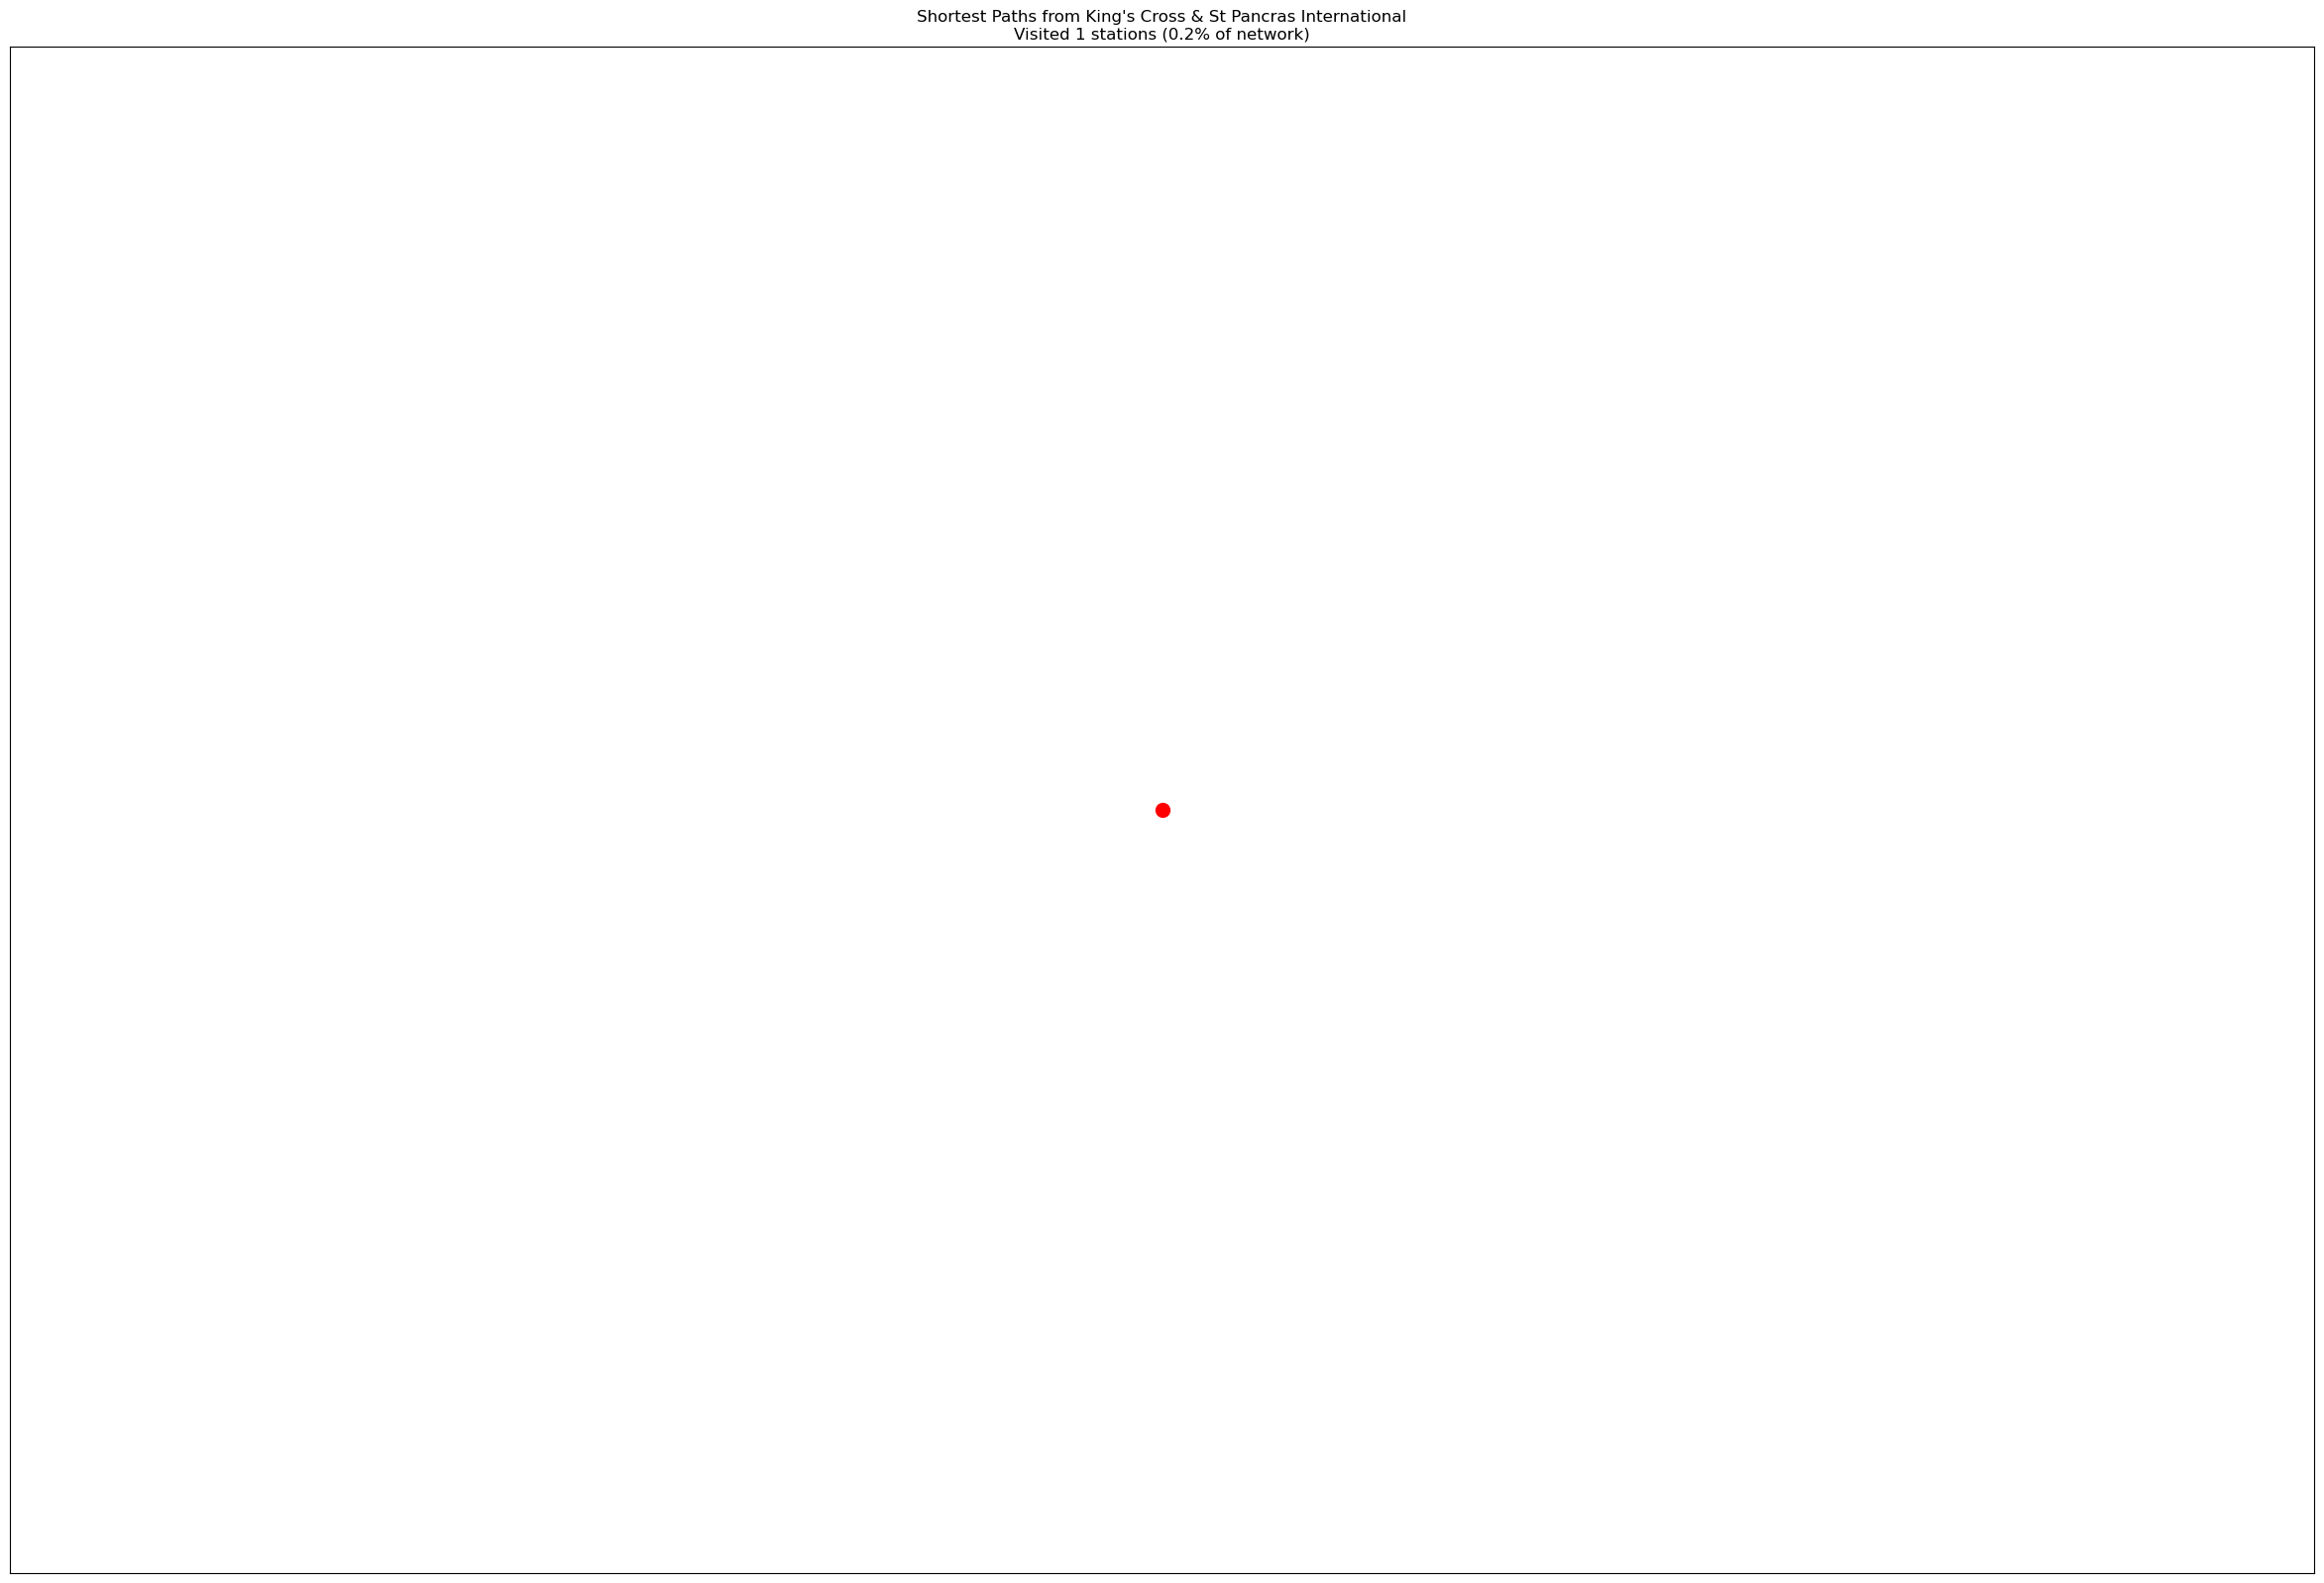

In [5]:
start_node = 249 # Choose a central station
anim = create_shortest_paths_animation(G, start_node, pos, colors)
anim.save('shortest_paths_colored.gif', writer='pillow')